# Feature Generation Pipeline

This notebook demonstrates the streamlined pipeline approach for DIA-Aspire-Rescore feature generation.

For step-by-step details, see `01_step_by_step_feature_generation.ipynb`.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import matplotlib.pyplot as plt
from peptdeep.rescore.fdr import calc_fdr

from dia_aspire_rescore.pipeline import Pipeline
from dia_aspire_rescore.config import FineTuneConfig, IOConfig
from dia_aspire_rescore.plot import plot_target_decoy_dist, plot_qvalues

import logging
logging.basicConfig(level=logging.INFO)


## Configuration

In [2]:
output_dir = Path('../output/pipeline')
output_dir.mkdir(parents=True, exist_ok=True)

io_config = IOConfig(
    report_file="../../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet",
    ms_file_dir="../output",
    ms_file_type="hdf5",
    output_dir=str(output_dir),
)

finetune_config = FineTuneConfig(
    fdr_threshold=0.01,
    instrument='QE',
    nce=27,
    psm_num_to_train_ms2=8000,
    epoch_to_train_ms2=20,
    epoch_to_train_rt_ccs=25,
    train_verbose=True,
)

## Run Pipeline

In [3]:
pipeline = Pipeline(
    io_config=io_config,
    finetune_config=finetune_config,
    feature_generators=["basic", "ms2", "rt"],
)

psm_df = pipeline.run_feature_generation()

2025-12-14 20:07:47> Found 2 MS files


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alphabase/psm_reader/psm_reader.py:342: UserWarning: Unknown modifications: {'Q(UniMod:1)'}. Precursors with unknown modifications will be removed.
  warnings.warn(


2025-12-14 20:07:51> Loaded 338839 PSMs


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/model/ms2.py:416: UserWarning: mask_modloss is deprecated and will be removed in the future. To mask the modloss fragments, the charged_frag_types should not include the modloss fragments.
  warnings.warn(


2025-12-14 20:07:52> Selected 83145 PSMs for training (FDR < 0.01)


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]

2025-12-14 20:07:57> Matched 83145 PSMs with spectra
2025-12-14 20:07:57> Training MS2 model...
2025-12-14 20:07:57> 8135 PSMs for MS2 model training/transfer learning
2025-12-14 20:07:57> Training with fixed sequence length: 0


[Training] Epoch=1, lr=2e-05, loss=0.07879400018014406
[Training] Epoch=2, lr=3e-05, loss=0.07084454458795096
[Training] Epoch=3, lr=4e-05, loss=0.06515758896344587
[Training] Epoch=4, lr=5e-05, loss=0.061678956801954066
[Training] Epoch=5, lr=6e-05, loss=0.059308105589527836
[Training] Epoch=6, lr=7e-05, loss=0.057778627268577874
[Training] Epoch=7, lr=8e-05, loss=0.0560825614160613
[Training] Epoch=8, lr=9e-05, loss=0.054977347584147206
[Training] Epoch=9, lr=0.0001, loss=0.054123270472413616
[Training] Epoch=10, lr=0.0001, loss=0.0533927967281718
[Training] Epoch=11, lr=9.755282581475769e-05, loss=0.05267312828647463
[Training] Epoch=12, lr=9.045084971874738e-05, loss=0.05206400705011267
[Training] Epoch=13, lr=7.938926261462366e-05, loss=0.05138402138101427
[Training] Epoch=14, lr=6.545084971874738e-05, loss=0.050972338765859604
[Training] Epoch=15, lr=5e-05, loss=0.05053596178952016
[Training] Epoch=16, lr=3.4549150281252636e-05, loss=0.05012660022628935
[Training] Epoch=17, lr=2.

100%|██████████| 2/2 [00:04<00:00,  2.33s/it]


2025-12-14 20:13:00> Predicting MS2 ...


100%|██████████| 7/7 [01:25<00:00, 12.27s/it]


2025-12-14 20:14:56> Added 51 features
2025-12-14 20:14:56> Generating rt features...
2025-12-14 20:14:56> Predicting RT ...


100%|██████████| 7/7 [00:35<00:00,  5.06s/it]

2025-12-14 20:15:31> Added 4 features


2025-12-14 20:15:39> Saved to ../output/pipeline/psm.csv


## Feature Evaluation

<Axes: xlabel='spc', ylabel='Density'>

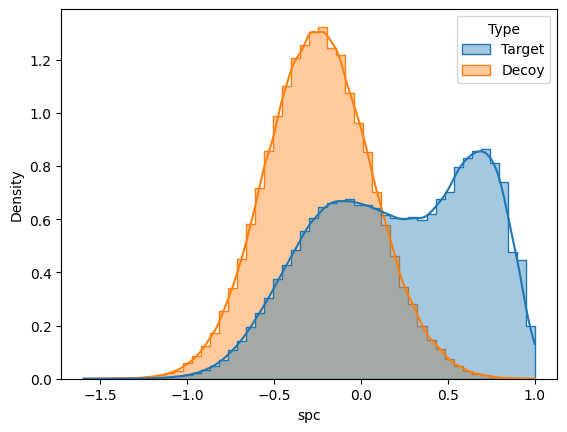

In [4]:
plot_target_decoy_dist(psm_df, metric="spc")

<Axes: xlabel='abs_rt_delta', ylabel='Density'>

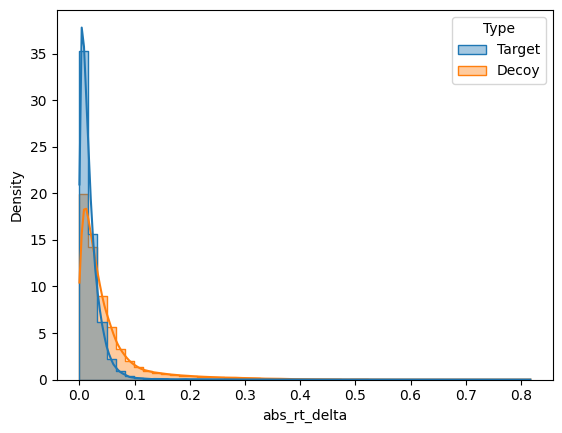

In [5]:
plot_target_decoy_dist(psm_df, metric="abs_rt_delta")

In [7]:
from dia_aspire_rescore.features import MS2FeatureGenerator, RTFeatureGenerator
# get the feature names
ms2_generator = MS2FeatureGenerator(model_mgr=pipeline.finetuner.model_manager, ms_files=pipeline.ms_files, ms_file_type=io_config.ms_file_type, ms2_match_config=pipeline.ms2_match_config)
rt_generator = RTFeatureGenerator(model_mgr=pipeline.finetuner.model_manager)

for feature in ms2_generator.feature_names + rt_generator.feature_names:
    psm_df_eval = calc_fdr(psm_df, score_column=feature)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_target_decoy_dist(psm_df_eval, feature, ax=axes[0])
    axes[0].set_title(f'{feature} - Target/Decoy Distribution')
    
    threshold = 0.1
    if psm_df_eval['fdr'].min() > 0.1:
        threshold = 0.5
    plot_qvalues(psm_df_eval['fdr'], threshold=threshold, ax=axes[1])
    axes[1].set_title(f'{feature} - Discoveries at FDR')
    plt.tight_layout()
    
    pdf_path = output_dir / f'{feature}.pdf'
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.close()

/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / target_cumsum
/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/rescore/fdr.py:61: RuntimeWarning: divide by zero encountered in divide
  fdr_values = decoy_cumsum / targ